### Описание задания

Классификация по тональности отзывов на банки с сайта banki.ru.
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.
Тексты хранятся в json-ах в массиве responses.

### Задачи
**Часть 1. Анализ текстов**

**1.1** Посчитать количество отзывов в разных городах и на разные банки

**1.2** Построить гистограмы длин слов отзывов в символах и в словах

**1.3** Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

**1.4** Построить кривые Ципфа и Хипса

**1.5** Ответить на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

**1.6** В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Использовать меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

**Часть 2. Тематическое моделирование**

**2.1** Построить несколько тематических моделей коллекции документов с разным числом тем. Привести примеры понятных (интерпретируемых) тем.

**2.2** Найти темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

**Часть 3. Классификация текстов**

**3.1** Сформулировать для простоты задачу бинарной классификации: классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

**3.2** Составить обучающее и тестовое множество: выбрать из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Использовать sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

**3.3** Использовать любой известный алгоритм классификации текстов для решения задачи и получите baseline. Сравнить разные варианты векторизации текста: с использованием только униграм, пар или троек слов или с использованием символьных n-грам.

**3.4** Сравнить, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

- преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD);
- тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import bz2
import gdown
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pymorphy2
import re
import regex
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
from string import punctuation
from tqdm import tqdm

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics  import classification_report

### Скачивание данных

In [2]:
url = 'https://drive.google.com/uc?id=1OelGGXPXBinXvZnDb1Bmmxe4rtdBmqdk'

In [3]:
gdown.download(url, quiet=True)

'banki_responses.json.bz2'

In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:11, 1530.84it/s]


In [5]:
size = len(responses)
size

153499

### Часть 1. Анализ текстов
#### 1.1 Посчитать количество отзывов в разных городах и на разные банки

In [6]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [7]:
city_response = df['city'].value_counts()
city_response.head(10)

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
Name: city, dtype: int64

In [8]:
banks_response = df['bank_name'].value_counts()
banks_response.head(10)

Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: bank_name, dtype: int64

#### 1.2 Построить гистограмы длин отзывов в символах и в словах
Подсчёт будем производить сразу исключая стоп-слова и пунктуацию

In [9]:
noise = stopwords.words('russian') + list(punctuation)

In [10]:
vec_words = CountVectorizer(ngram_range=(1, 1), stop_words=noise)
bow_words = vec_words.fit_transform(df['text'])
vec_symbol = CountVectorizer(analyzer='char')
bow_symbol = vec_symbol.fit_transform(df['text'])

In [12]:
ln_words = []
ln_symbol = []
for i in tqdm(range(size)):
    ln_words.append(np.sum(bow_words[i].todense()))
    ln_symbol.append(np.sum(bow_symbol[i].todense()))

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [06:23<00:00, 400.21it/s]


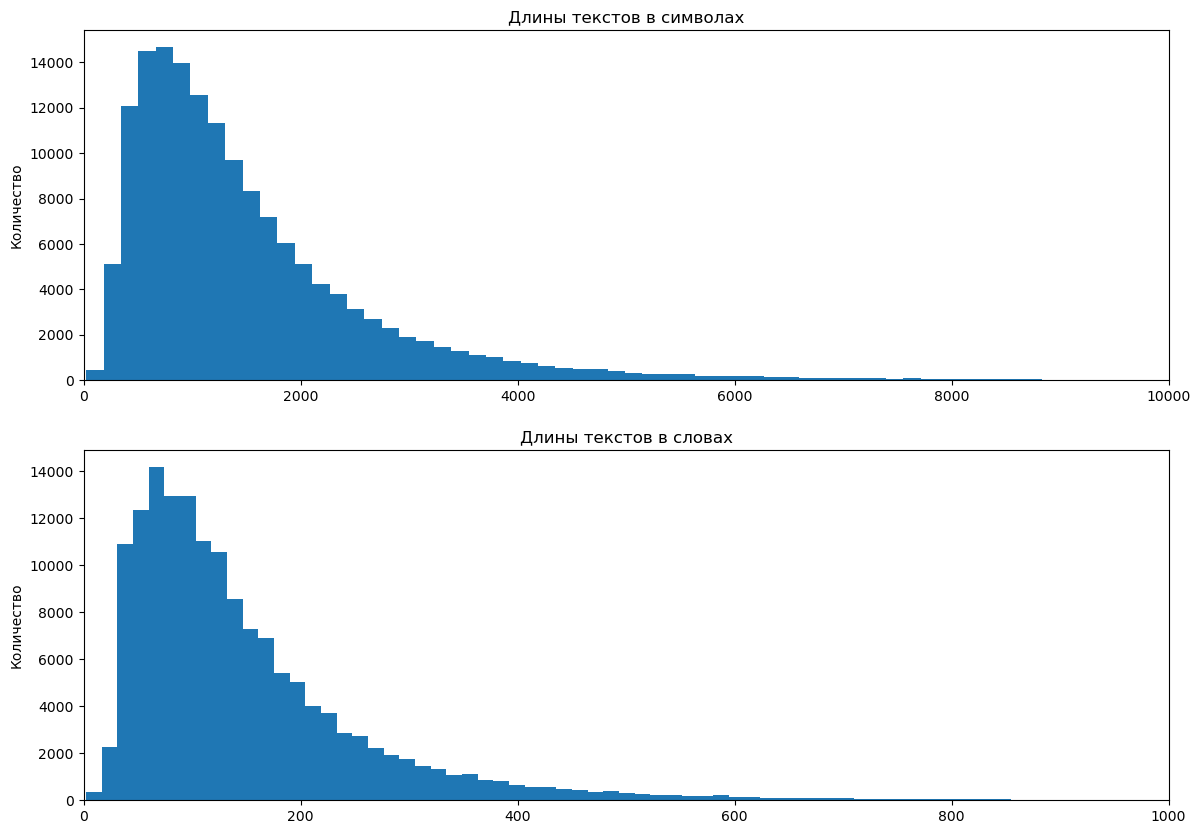

In [27]:
fig, axes = plt.subplots(2, 1,figsize=(14,10))

axes[0].hist(ln_symbol, bins = 200)
axes[1].hist(ln_words, bins = 200)
axes[0].set_xlim(0, 10000)
axes[1].set_xlim(0, 1000)
axes[0].set_title('Длины текстов в символах')
axes[1].set_title('Длины текстов в словах')
axes[0].set_ylabel('Количество')
axes[1].set_ylabel('Количество')
fig.show()

#### 1.3 Найдите 10 самых частых:

- слов

In [37]:
corpus = [token for response in df.text for token in word_tokenize(response) if token not in punctuation]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235176)]

- слов без стоп-слов

In [ ]:
corpus = [word for word in corpus if word not in stopwords.words('russian')]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

- лемм

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
lemmas = [morph.parse(word)[0].normal_form for word in corpus]
freq_dict_lemm = Counter(lemmas)
freq_dict_lemm.most_common(10)

- существительных

In [ ]:
noun = [word for word in lemmas if morph.parse(word)[0].tag.POS=='NOUN']
freq_dict_noun = Counter(noun)
freq_dict_noun.most_common(10)

#### 1.4 Построить кривые Ципфа и Хипса

In [ ]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
ax.set_title(u'Кривая Ципфа', fontsize=12)
plt.show()

In [ ]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.text.iterrows(), total = len(X)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
ax.set_title(u'Кривая Хипса', fontsize=12)
plt.show()

#### 1.5 Ответить на следующие вопросы:

- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [ ]:
for val in ["сотрудник", "клиент", "мошенничество", "доверие"]:
    print(val, freq_dict.get(val))

#### 1.6 В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Использовать меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
positive = df.loc[df.rating_grade==5]
negative = df.loc[df.rating_grade==1]